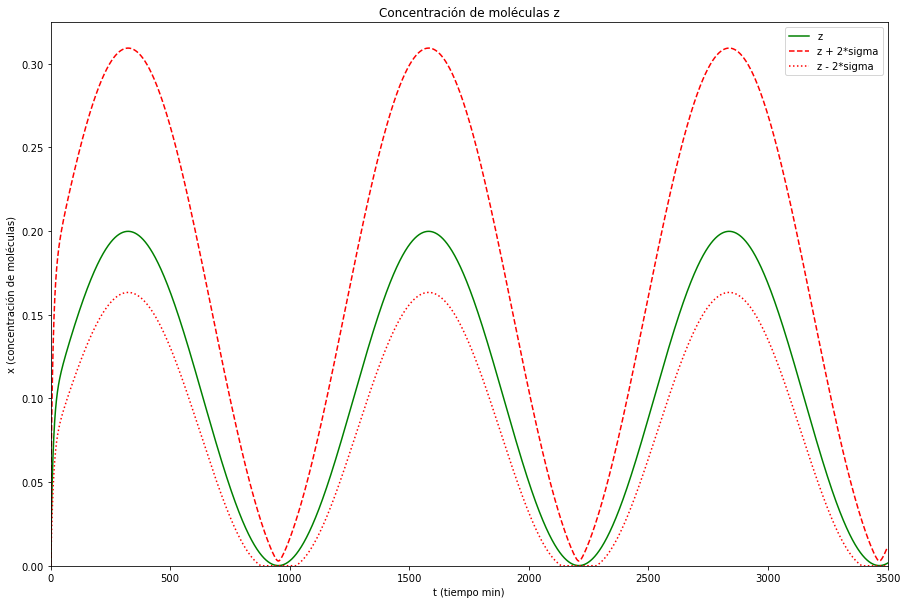

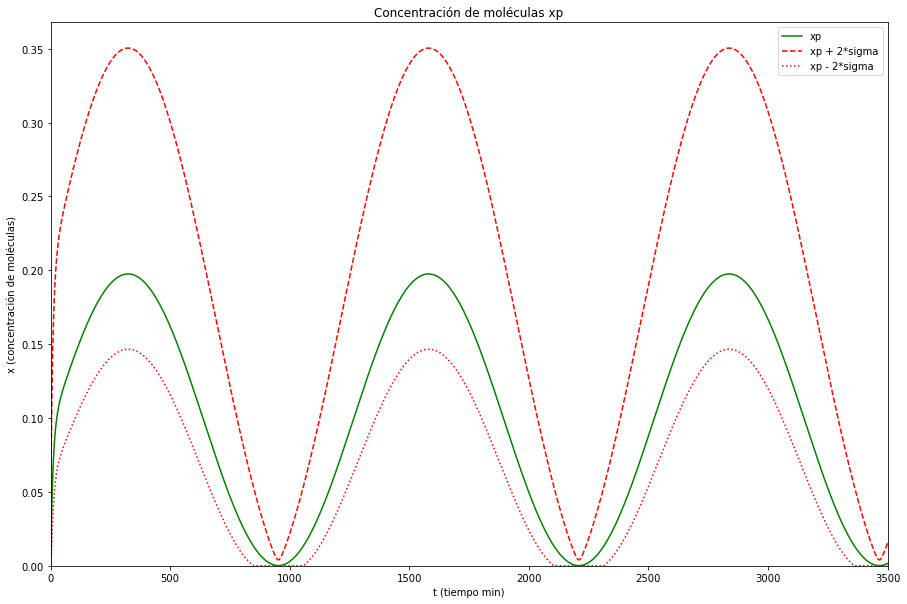

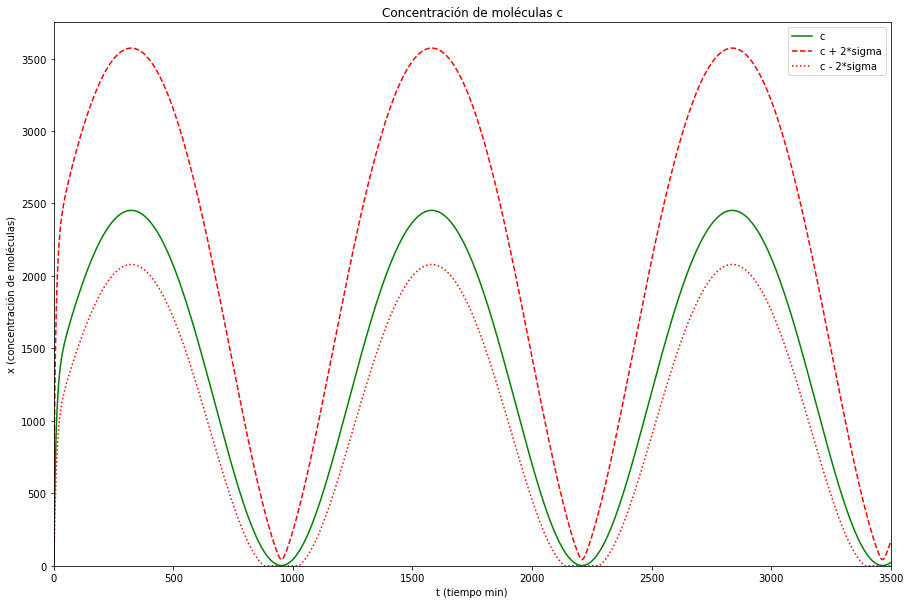

In [1]:
'programa para dinamica determinista con fluctuaciones'


#importamos librerias
import numpy as np 
import matplotlib.pyplot as plt 
import math 
from scipy.integrate import odeint
import numdifftools as nd 
  
#para implementar el algoritmo son necesarias algunas cantidades y definir algunos parametros
#condiciones iniciales de las variables involucradas y el tiempo

def z(t):
    return 0.01*(1+ math.sin(0.005*t))

t0=0 #tiempo inicial
tf= 3500 # tiempo final
t1=5
Omega= 150 #tamano del sistema
x=[0, 1500*Omega, 0, 1500*Omega, 100*Omega, 0] #vector de condiciones iniciales [X0,Y0,Z0]
h= 1 #numero de veces para realizar la misma simulacion
n= len(x) #numero de especies quimicas involucradas

#varianza inicial
sigma_0=np.zeros(n**2)

#parametros
k1=[50,50,10]  #vector de k+
k2=[0, 0, 10]  #vector de k-

#matrices de coeficientes estequiometricos
alpha= [[1,1,0,0,0,0],
        [0,0,1,1,0,0],
        [0,0,1,0,1,0],
        [0,0,0,0,0,0]]

beta1= [[1,0,1,0,0,0],
       [0,1,0,1,0,0],
       [0,0,0,0,0,1],
       [1,0,0,0,0,0]]

#contruimos la matriz estequiometrica 'evitar editar a partir de esta linea'
S= np.subtract( beta1,alpha)
S=S.T

#definimos unas funciones
def Gradvector(f,variables):  #calcula el hessiano de un vector
    l1=len(f)
    G=np.zeros([l1,n])
    for i in range(l1):
         G[i]= nd.Gradient(f[i])(variables)
    return G

def Hessvector(f,variables):  #calcula el hessiano de un vector
    l1=len(f)
    H=np.zeros([l1,n,n])
    for i in range(l1):
         H[i]= nd.Hessian(f[i])(variables)
    return H

def sumasAB(A,B): #funcion para sumar entrada por entrada cada matriz
    l1=len(A)
    l2=0
    for i in range(l1):
        for j in range(l1):
            l2 +=  A[i][j]*B[i][j]
    return l2

def contraer1(A,B): #contrae matrices
    l1=np.zeros([n,n,n])
    for i in range(n):
        for j in range(4):
            l1[i,:] += A[i,j]*B[j,:,:]
    return l1

def contraer2(A,B): #contrae matriz y tensor
    l1=np.zeros([n,n])
    for i in range(n):
        for j in range(4):
            l1[i,:] += A[i,j]*B[j,:]
    return l1

def contraer3(S1,S2): #construye entradas
    l1=np.zeros(4)
    for i in range(4):
        l1[i]=S1[i]*S2[i]
    return l1

def contraer4(S1,T): #contrae vector y tensor
    l1=np.zeros([n,n])
    for i in range(4):
        l1[:] += S1[i]*T[i,:,:]
    return l1

def evaluarvector(vec,variables): #evaluar un vector de función lamda
    l1=4
    l2=np.zeros(l1)
    for i in range(l1):
        l2[i]=vec[i](variables)
    return l2

def rehacer(A): #restructura matriz
    l1=np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            l1[i,j]=A[i+1,j]
    return l1

#escribimos los vectores de propension            
ni = [lambda Y: k1[0]*Y[0]*Y[1], lambda Y: k1[1]*Y[2]*Y[3], lambda Y: k1[2]*Y[2]*Y[4], lambda Y: z(t0)] #vector de propension ni+
ni_ = [lambda Y: 0 , lambda Y: 0, lambda Y: k2[2]*Y[5], lambda Y: 0.1*Y[0]] #vector de propension ni-

hessni=Hessvector(ni,x)   #hessiano de ni+, se omite el otro ya que es cero
T1=contraer1(S,hessni) #contraemos el hessiano con la matriz estequiometrica

gradni_=Gradvector(ni_,x) #gradiende de ni-
T3=contraer2(S,gradni_) #contraemos el gradiente de ni+ con la matriz estequiometrica

x=np.r_[x,sigma_0] # construimos un vector con x y sigma iniciales

# funcion para construir la ecuacion diferencial
def Sistema(State,t):
        
    Y  = State 

    #restructuramos el vector de entrada    
    Y=Y.reshape(7,6)

    #escribimos los vectores de propension
    ni = [lambda Y: k1[0]*Y[0]*Y[1], lambda Y: k1[1]*Y[2]*Y[3], lambda Y: k1[2]*Y[2]*Y[4], lambda Y: z(t)] #vector de propension ni+
    ni_ = [lambda Y: 0 , lambda Y: 0, lambda Y: k2[2]*Y[5], lambda Y: 0.1*Y[0]] #vector de propension ni-

    gradni=Gradvector(ni,Y[0]) #gradiende de ni+
    T2=contraer2(S,gradni) #contraemos el gradiente de ni+ con la matriz estequiometrica
    
    #evaluar los vectores ni+-
    ni=evaluarvector(ni,Y[0]) 
    ni_=evaluarvector(ni_,Y[0])

    #se crean los terminos de derivada temporal
    Y_dot=np.zeros(n)
    sigma_dot= np.zeros([n,n])
    
    #construimos a sigma
    sigma=rehacer(Y)

    #evaluamos las derivadas temporales
    for i in range(n):
        Y_dot[i]= np.dot(S[i],ni) - np.dot(S[i],ni_) + sumasAB(sigma,T1[i,:,:])

    for i in range(n):
        for j in range(i,n):
            sigma_dot[i,j]=sigma_dot[j,i]= (np.dot(contraer3(S[i],S[j]),ni/Omega) + np.dot(contraer3(S[i],S[j]),ni_/Omega) 
                                           + np.dot(sigma[i],T2[j])- np.dot(sigma[i],T3[j] ) + np.dot(sigma[j],T2[i])- np.dot(sigma[j],T3[i] )
                                           + sumasAB(sigma, contraer4(contraer3(S[i],S[j]),hessni))/(2*Omega))
                                                       
    #rescribimos a sigma como vector
    sigma_dot=sigma_dot.reshape(1,n*n)
    
    #escribimos a Y_dot y sigma_dot como un vector
    l4=np.r_[Y_dot,sigma_dot[0]]

    return l4

#A resolver
t = np.arange(0,tf,0.001) #construimos el rango de t
State = odeint(Sistema,x,t)
Y = State.T

#funciones para poder graficar
def raiz(vec): #funcion para sacar raiz a las entradas de un vector
    l1=len(vec)
    for i in range(l1):
        if vec[i]>=0:
            vec[i]=math.sqrt(vec[i])
        else:
            vec[i]=0
    return vec

def heav(vec): #funcion que devuelve solo valores mayores que cero
    l1=len(vec)
    for i in range(l1):
        if vec[i]>=0:
            vec[i]=vec[i]                 
        else:
           vec[i]=0  
    return vec

#sacamos la raiz al vector para encontrar la desviacion
Y[6]= raiz(Y[6])
Y[20]= raiz(Y[20])
Y[41]= raiz(Y[41])

#promedios menos 2*sigma
ru=1
Ysigma1=heav(Y[0]-ru*Y[6])
Ysigma2=heav(Y[2]-ru*Y[20])
Ysigma3=heav(Y[5]-ru*Y[41])

# A graficar
fig1 = plt.figure(1,figsize=(15,10)) 
plt.title( 'Concentración de moléculas z' )
plt.plot(t,Y[0],color='green', label= 'z')
plt.plot(t,(Y[0]+3*Y[6]),'--', color="red" , label= 'z + 2*sigma')
plt.plot(t,Ysigma1,':', color="red", label= 'z - 2*sigma')
plt.xlabel("t (tiempo min)")
plt.ylabel("x (concentración de moléculas)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()

fig2 = plt.figure(2,figsize=(15,10))
plt.title( 'Concentración de moléculas xp' )
plt.plot(t,Y[2],color='green', label='xp')
plt.plot(t,(Y[2]+3*Y[20]),'--', color="red", label= 'xp + 2*sigma')
plt.plot(t,Ysigma2,':', color="red", label= 'xp - 2*sigma')
plt.xlabel("t (tiempo min)")
plt.ylabel("x (concentración de moléculas)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()

fig3 = plt.figure(3,figsize=(15,10))
plt.title( 'Concentración de moléculas c' )
plt.plot(t,Y[5],color='green', label='c')
plt.plot(t,(Y[5]+3*Y[41]),'--', color="red", label= 'c + 2*sigma')
plt.plot(t, Ysigma3, ':', color="red", label= 'c - 2*sigma')
plt.xlabel("t (tiempo min)")
plt.ylabel("x (concentración de moléculas)")
plt.xlim(0, tf)
plt.ylim(0)
plt.legend()

plt.show()